[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/068_pytorch_profiling/068_pytorch_profiling.ipynb)

# Pytorch - Profiling

En posts anteriores hemos visto mucho ejemplos de lo que podemos llegar a hacer con [Pytorch](https://pytorch.org/), nuestra librería favorita (al menos de momento 😛) para implementar y entrenar redes neuronales. Sin embargo nunca nos hemos preocupado por cómo de óptimo era nuestro código. En este post y los que vienen a continuación nos vamos a encargarnos precisamente de ello. 

Para empezar, vamos a reutilizar el código para entrenar una red convolucional en el dataset CIFAR10 que ya hemos usado en posts anteriores. Primero definimos nuestro `Dataset`, que se encargará de leer las imágenes.

In [2]:
import torch
import torchvision
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, train=True):
        trainset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True)
        self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
        self.imgs, self.labels = np.array([np.array(i[0]) for i in trainset]), np.array([i[1] for i in trainset])
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, ix):
        img = self.imgs[ix]
        return torch.from_numpy(img / 255.).permute(2,0,1).float(), torch.tensor(self.labels[ix]).long()
    
ds = {
    'train': Dataset(),
    'test': Dataset(train=False)
}


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


A continuación definimos el `DataLoader`, que se encargará de alimentar la red neuronal con `batches` de imágenes.

In [3]:
batch_size = 32

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False)
}

In [4]:
imgs, labels = next(iter(dl['train']))
imgs.shape, labels.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

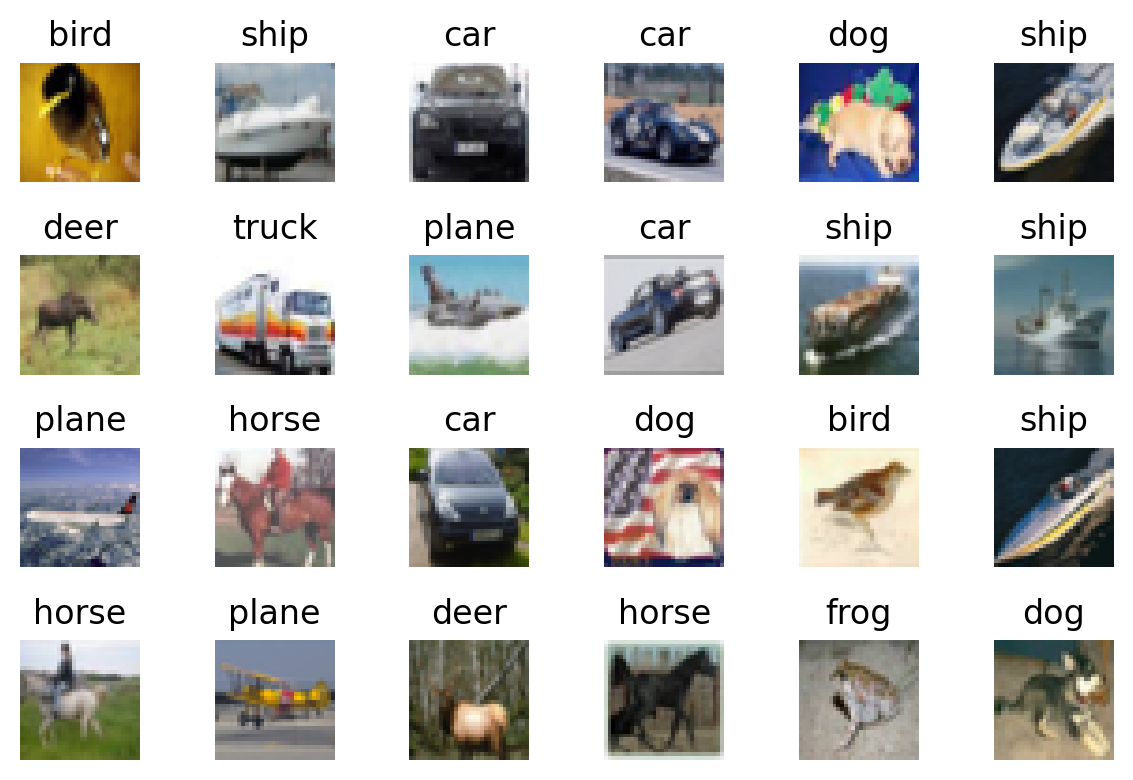

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(dpi=200)
c, r = 6, 4
for j in range(r):
    for i in range(c):
        ix = j*c + i
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.imshow(img.permute(1,2,0))
        ax.set_title(ds['train'].classes[label.item()])
        ax.axis('off')
plt.tight_layout()
plt.show()

Usaremos una `resnet18` pre-entranada a la cual cambiaremos la última capa para poder llevar a cabo la tarea de clasificación en 10 clases.

In [15]:
import torch.nn.functional as F

class Model(torch.nn.Module):

    def __init__(self, n_outputs=10):
        super().__init__()
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.fc = torch.nn.Linear(512, n_outputs)

    def forward(self, x):
        return self.model(x)

In [42]:
model = Model()
output = model(torch.randn(32, 3, 32, 32))

output.shape

torch.Size([32, 10])

A continuación definimos nuestras funciones de entrenamiento.

In [68]:
from tqdm import tqdm

def step(model, batch, device):
    x, y = batch
    x, y = x.to(device), y.to(device)
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.size(0)
    return loss, acc

def train(model, dl, optimizer, epochs=10, device="cpu", prof=None, end=0):
    model.to(device)
    hist = {'loss': [], 'acc': [], 'test_loss': [], 'test_acc': []}
    for e in range(1, epochs+1):
        # train
        model.train()
        l, a = [], []
        bar = tqdm(dl['train'])
        stop=False
        for batch_idx, batch in enumerate(bar):
            optimizer.zero_grad()
            loss, acc = step(model, batch, device)
            loss.backward()
            optimizer.step()
            l.append(loss.item())
            a.append(acc)
            bar.set_description(f"training... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
            # profiling
            if prof:
                if batch_idx >= end:
                    stop = True
                    break
                prof.step()  
        hist['loss'].append(np.mean(l))
        hist['acc'].append(np.mean(a))
        if stop:
            break
        # eval
        model.eval()
        l, a = [], []
        bar = tqdm(dl['test'])
        with torch.no_grad():
            for batch in bar:
                loss, acc = step(model, batch, device)
                l.append(loss.item())
                a.append(acc)
                bar.set_description(f"testing... loss {np.mean(l):.4f} acc {np.mean(a):.4f}")
        hist['test_loss'].append(np.mean(l))
        hist['test_acc'].append(np.mean(a))
        # log
        log = f'Epoch {e}/{epochs}'
        for k, v in hist.items():
            log += f' {k} {v[-1]:.4f}'
        print(log)
        
    return hist

Finalmente, podemos entrenar nuestro modelo.

In [18]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

hist = train(model, dl, optimizer, epochs=3)

training... loss 0.8019 acc 0.7188:   0%|          | 3/1563 [00:00<01:16, 20.31it/s]

Epoch 1/3 loss 1.0930 acc 0.6304 test_loss 0.9886 test_acc 0.6755


training... loss 0.5882 acc 0.8281:   0%|          | 3/1563 [00:00<01:16, 20.28it/s]

Epoch 2/3 loss 0.7577 acc 0.7452 test_loss 0.7643 test_acc 0.7420


testing... loss 0.7600 acc 0.7496: 100%|██████████| 313/313 [00:03<00:00, 91.55it/s] 

Epoch 3/3 loss 0.6391 acc 0.7842 test_loss 0.7600 test_acc 0.7496


Si bien hemos conseguido nuestro objetivo de entrenar esta red neuronal, ¿acaso lo hemos hecho de la manera más óptima? O dicho de otra manera, ¿sería posible utilizar el hardware que tenemos a nuestra disposición para poder entrenar nuestro modelo más rápido? Para poder responder a estas preguntas necesitamos alguna manera de *trackear* todas las operaciones que tienen lugar durante el entrenamiento y guardar el tiempo o memoria utilizado por cada una de ellas. Para ello, `Pytorch` nos oferece su `Profiler`.

## El `Profiler`

Lo primero que podemos medir es el tiempo que nuestro modelo invierte en cada una de las operaciones involucradas.

> El `profiler` fue introducido en la versión 1.8.1 de `Pytorch`, así que aségurate de tener una versión compatible !

In [20]:
from torch.profiler import profile, record_function, ProfilerActivity

torch.__version__

'1.8.1'

In [23]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        model(torch.randn(32, 3, 32, 32))

In [25]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=20))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference        10.91%       2.392ms        99.72%      21.856ms      21.856ms             1  
                     aten::conv2d         0.68%     149.000us        56.77%      12.442ms     622.100us            20  
                aten::convolution         0.67%     146.000us        56.09%      12.293ms     614.650us            20  
               aten::_convolution         1.13%     247.000us        55.42%      12.147ms     607.350us            20  
         aten::mkldnn_convolution        53.72%      11.774ms        54.30%      11.900ms     595.000us            20  
                 aten::batch_norm       

Podemos ver que nuestro modelo se pasa la mayor parte del tiempo calculando convoluciones, y después *batch norm*. Algo importante a remarcar es la diferencia en `Self CPU` y `CPU total`. En el primer caso se calcula el tiempo invertido en el operador, pero no en llamadas a otros operadores, lo cual sí ocurre en el segundo caso.

Podemos agrupar los operadores por tamaños de tensores para obtener más información.

In [28]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                   Input Shapes  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ---------------------------------------------  
                  model_inference        10.91%       2.392ms        99.72%      21.856ms      21.856ms             1                                             []  
                     aten::conv2d         0.12%      26.000us        14.27%       3.128ms     782.000us             4  [[32, 64, 8, 8], [64, 64, 3, 3], [], [], [],   
                aten::convolution         0.15%      32.000us        14.15%       3.102ms     775.500us             4  [[32, 64, 8, 8], [64, 64, 3, 3], [], [], [],  

Y también visualizar la cantidad de memoria utilizada por el modelo.

In [44]:
with profile(activities=[ProfilerActivity.CPU], profile_memory=True, record_shapes=True) as prof:
    model(torch.randn(32, 3, 32, 32))
          
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                      aten::empty         1.46%     490.000us         1.46%     490.000us       4.667us      12.85 Mb      12.85 Mb           105  
                    aten::resize_         0.03%      11.000us         0.03%      11.000us       5.500us       1.50 Mb       1.50 Mb             2  
                      aten::addmm         0.22%      74.000us         0.26%      88.000us      88.000us       1.25 Kb       1.25 Kb             1  
                        aten::add         0.97%     324.000us         0.97%     324.000us      16.200us         

## Mejora 1 - Ejección en GPU

Si estas familiarizado con el entrenamiento de redes neuronales, o has seguido un poco la actividad en este blog, no te sorprenderá que la primera mejora que podemos hacer a nuestro código es la de entrenar el modelo en la `GPU`. 

In [49]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

hist = train(model, dl, optimizer, epochs=3, device="cuda")

training... loss 0.9434 acc 0.6897:   1%|          | 8/1563 [00:00<00:21, 71.66it/s]

Epoch 1/3 loss 1.1143 acc 0.6274 test_loss 1.0616 test_acc 0.6560


training... loss 0.6705 acc 0.7790:   1%|          | 8/1563 [00:00<00:21, 71.25it/s]

Epoch 2/3 loss 0.7789 acc 0.7404 test_loss 0.8353 test_acc 0.7164


testing... loss 0.7857 acc 0.7637: 100%|██████████| 313/313 [00:01<00:00, 239.56it/s]

Epoch 3/3 loss 0.6476 acc 0.7855 test_loss 0.7857 test_acc 0.7637


Podemos ejecutar el `profiler` también en la `GPU` de la siguiente manera.

In [50]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], profile_memory=True, record_shapes=True) as prof:
    with record_function("model_inference"):
        model(torch.randn(32, 3, 32, 32).cuda())

print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.12%       1.437ms       100.00%        1.160s        1.160s       0.000us         0.00%       1.782ms       1.782ms          -4 b    -384.02 Kb           0 b     -14.31 M

Para poder analizar mejor estos resultados, vamos a exportarlos como archivo `json` y abrirlo en `chrome://tracing/`.

In [51]:
prof.export_chrome_trace("trace.json")

Si bien `Pytorch` nos ofrece herramientas para inspeccionar nuestro modelo, es más probable que quiera evaluar todo tu código de entrenamiento para encontrar posibles cuellos de botella. Esto lo podemos hacer de la siguiente manera.

In [69]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18'),
        record_shapes=True,
        with_stack=True
) as prof:
    
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    hist = train(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 2.4419 acc 0.2244:   1%|          | 10/1563 [00:06<18:00,  1.44it/s]


El resultado lo podrás encontrar en `./log/resnet18` y podrás visualizarlo con el plugin de `Pytorch` para `Tensorboard`, que además te sugerirá mejoras automáticamente.

> Puedes instalar el plugin con `pip install torch_tb_profiler`

## Mejora 2 - Usar `workers` en el `DataLoader`

Una de las mejoras que nos sugiere es cargar nuestras imágenes en paralelo, lo cual podemos hacer de la siguiente manera.

In [74]:
batch_size = 32

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=8)
}

In [75]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18_8workers'),
        record_shapes=True,
        with_stack=True
) as prof:
    
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    hist = train(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 2.3567 acc 0.2528:   1%|          | 10/1563 [00:08<21:39,  1.19it/s]


## Mejora 3 - Aumentar el `batch size`

Otra mejora que nos sugieren es aumentar el `batch size` ya que estamos utilizando nuestra `GPU` muy por debajo de sus posibilidades.

In [76]:
batch_size = 2048

dl = {
    'train': torch.utils.data.DataLoader(ds['train'], batch_size=batch_size, shuffle=True, num_workers=8),
    'test': torch.utils.data.DataLoader(ds['test'], batch_size=batch_size, shuffle=False, num_workers=8)
}

In [77]:
with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/resnet18_8workers_2048bs'),
        record_shapes=True,
        with_stack=True
) as prof:
    
    model = Model()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    hist = train(model, dl, optimizer, epochs=3, device="cuda", prof=prof, end=(1 + 1 + 3) * 2)

training... loss 1.3451 acc 0.5403:  40%|████      | 10/25 [00:09<00:13,  1.08it/s]


Con estas mejoras podemos ahora entrenar nuestro modelo.

> Ten en cuenta que usar un `batch size` elevado puede tener consecuencias a la hora de la opimización, es posible que tengas que ajusta el `learning rate` de manera acorde.

In [79]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
hist = train(model, dl, optimizer, epochs=10, device="cuda")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/10 loss 1.0467 acc 0.6400 test_loss 0.9282 test_acc 0.7026


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/10 loss 0.5060 acc 0.8265 test_loss 0.7584 test_acc 0.7483


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/10 loss 0.3254 acc 0.8884 test_loss 0.6709 test_acc 0.7891


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/10 loss 0.2003 acc 0.9324 test_loss 0.7126 test_acc 0.7971


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/10 loss 0.1464 acc 0.9501 test_loss 0.8012 test_acc 0.7989


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/10 loss 0.1194 acc 0.9596 test_loss 0.9245 test_acc 0.7808


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/10 loss 0.0982 acc 0.9663 test_loss 0.8251 test_acc 0.8068


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 8/10 loss 0.0756 acc 0.9738 test_loss 0.9149 test_acc 0.8038


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 9/10 loss 0.0697 acc 0.9763 test_loss 0.9194 test_acc 0.7971


testing... loss 0.8824 acc 0.8139: 100%|██████████| 5/5 [00:01<00:00,  4.64it/s]

Epoch 10/10 loss 0.0583 acc 0.9796 test_loss 0.8824 test_acc 0.8139


Estupendo ! Hemos conseguido reducir el tiempo por *epoch* de 1 minuto y 18 segundos al entrenar en `CPU` a sólo 3 segundos al entrenar en `GPU` de manera óptima (en contra de los 21 segundos sin optimizar) y además obteniendo mejores métricas 🚀

## Resumen

En este post hemos introducido el `Profiler` de `Pytorch`, que nos poermite evaluar nuestro código para identificar posibles puntos de mejora. Además, gracias a la integración con `Tensorboard` podemos obtener sugerencias y visualizar todas las operaciones, tanto en `CPU` como en `GPU`. Hemos visto que entranando nuestro modelo en la `GPU`, usando `workers` para cargar imágenes en paralelo en el `DataLoader` y aumentando el `batch size` para aprovechar al máximo la `GPU` nos aportan unas mejoras nada desdeñables. En siguientes posts seguiremos viendo trucos para mejorar todavía más nuestro código.